# RTML Midterm 2021
# Chanapa Pananookooln st121395

1. In Lab 06, you fine tuned a Mask R-CNN model on the Cityscapes dataset. Download the image at http://www.cs.ait.ac.th/~mdailey/20201112_072342.jpg and run it through
   you model. Provide your source code to load the model, image, get the result, and display the result here. Display the resulting bounding boxes and masks. 

In [1]:
# load the image
# !wget http://www.cs.ait.ac.th/~mdailey/20201112_072342.jpg

In [129]:
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import utils
from coco_utils import get_city
import transforms

# Load the model
print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# load the fine-tuned weights into the model
model.load_state_dict(torch.load('../../weights/maskfinetunecity/maskrcnn_finetune_city_epoch9.pth'))

Loading pretrained model...


<All keys matched successfully>

In [130]:
from torchvision import datasets, models, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

# load the image into torchvision dataset
data = torchvision.datasets.ImageFolder('inference', transform = transform)

def collate_fn(batch):
    return tuple(zip(*batch))

# load the image into data loader
val_dataloader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [131]:
from get_free_gpu import get_free_gpu

device = get_free_gpu()
print(device)

model.to(device)

cuda:0


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [132]:
images, targets = next(iter(val_dataloader))

images = [img.to(device) for img in images]
print(len(images))

# get the prediction for the image
predictions = model(images)

print('Prediction keys:', list(dict(predictions[0])))
print('Boxes shape:', predictions[0]['boxes'].shape)
print('Labels shape:', predictions[0]['labels'].shape)
print('Scores shape:', predictions[0]['scores'].shape)
print('Masks shape:', predictions[0]['masks'].shape)

1
Prediction keys: ['boxes', 'labels', 'scores', 'masks']
Boxes shape: torch.Size([7, 4])
Labels shape: torch.Size([7])
Scores shape: torch.Size([7])
Masks shape: torch.Size([7, 1, 3024, 4032])


In [133]:
import numpy as np
import cv2
import random

# Array of labels for COCO dataset (91 elements)

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Random colors to use for labeling objects

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']

    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().numpy() * 255).astype(np.uint8)
    img = np.transpose(img,(1,2,0))
    img = np.flip(img, (0, 1))
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()

    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [ coco_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)

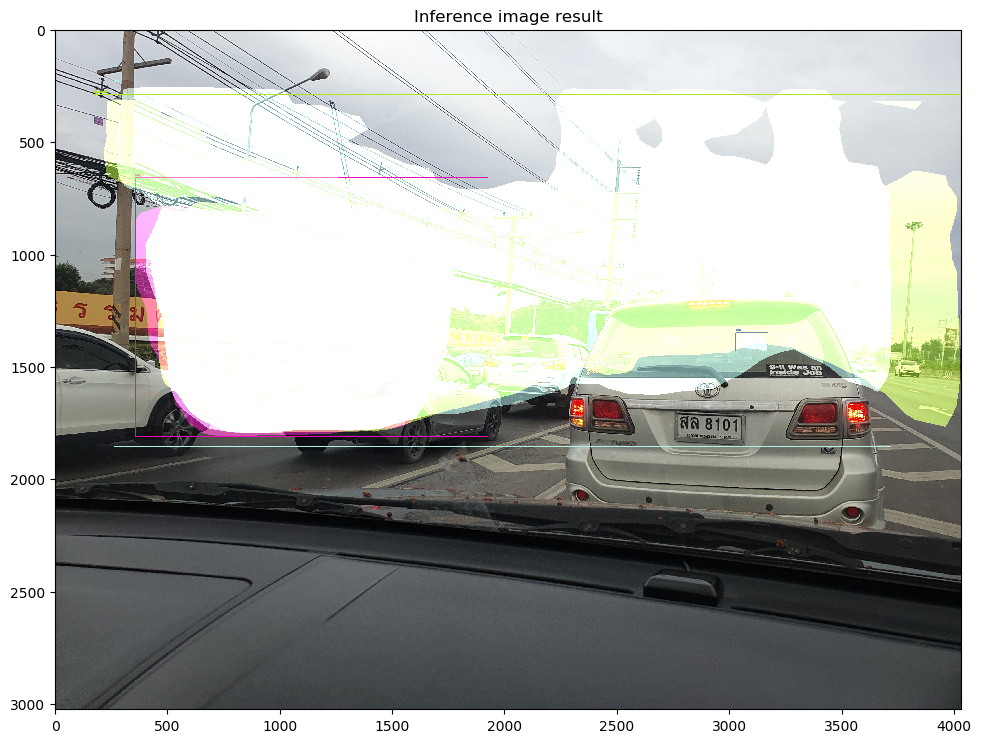

In [134]:
from matplotlib import pyplot as plt
import torch.nn.functional as F

masked_img = prediction_to_mask_image(images, predictions, 0, 0.1)

plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Inference image result')
plt.show()

Results : I need to lower the threshold to be able to see some masks that have lower scores. The masks shape are also not clear adn there is no labels for each box.
I think there is something wrong when I load and transform the data to input into the model. I could not fix it in time.

2. Write a program that samples 1000 points from a mixture of 4 2D Gaussians with identity covariance centered at (5,5), (10,5), (5,10), and (10,10).
   Provide the code and a plot of the sample.

In [66]:
# different means for each distribution
means = [[5, 5], [10, 5], [5, 10], [10, 10]]

# Identity matrix for covariance
cov = [[1, 0],
       [0, 1]]


x1, y1 = np.random.multivariate_normal(means[0], cov, 250).T
x2, y2 = np.random.multivariate_normal(means[1], cov, 250).T
x3, y3 = np.random.multivariate_normal(means[2], cov, 250).T
x4, y4 = np.random.multivariate_normal(means[3], cov, 250).T


datax = np.concatenate((x1,x2,x3,x4), axis = 0).reshape(-1,1)
datay = np.concatenate((y1,y2,y3,y4), axis = 0).reshape(-1,1)

data = np.concatenate((datax,datay), axis = 1)
print(data.shape)

(1000, 2)


## Plot the 1000 data samples

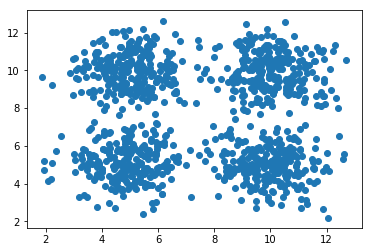

In [67]:
import matplotlib.pyplot as plt

plt.scatter(data[:,0], data[:,1])

# Creat the dataset class

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

from torch import nn, optim
from torchvision import transforms, datasets
%matplotlib inline

In [11]:
#%%
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
#%%

class midterm_dataset(Dataset):
    
    def __init__(self, transform=None):
        
        means = [[5, 5], [10, 5], [5, 10], [10, 10]]
        cov = [[1, 0],
               [0, 1]]


        x1, y1 = np.random.multivariate_normal(means[0], cov, 25000).T
        x2, y2 = np.random.multivariate_normal(means[1], cov, 25000).T
        x3, y3 = np.random.multivariate_normal(means[2], cov, 25000).T
        x4, y4 = np.random.multivariate_normal(means[3], cov, 25000).T


        datax = np.concatenate((x1,x2,x3,x4), axis = 0).reshape(-1,1)
        datay = np.concatenate((y1,y2,y3,y4), axis = 0).reshape(-1,1)

        self.data = np.concatenate((datax,datay), axis = 1)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        data = self.data[index]
            
        return data


## I increased the number of samples to 100000 so that GAN can learn the distribution better

3. Write a GAN generator G and discriminator D to model the dataset you generated in Question 2. Train the GAN and display two plots: a fake sample from the generator and the original sample from Question 2.

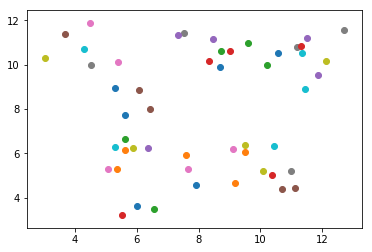

In [91]:
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

num_batches = len(data_loader)

for i, data in enumerate(data_loader):
    plt.scatter(data[i,0], data[i,1])
    if i == 50:
        break
plt.figure(figsize=(8,8))
plt.show()

In [14]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch



'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [15]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 2
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2)
        )

        self.out = nn.Sequential(
            nn.Linear(256, n_out)
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)

        x = self.out(x)
        return x

def noise(size):
    n = torch.randn(size, 2) # mean = 0, std = 1
    return n.to(device)

def plt_output(fake_data):
    plt.figure(figsize=(8,8))
    plt.xlim(0,15)
    plt.ylim(0,15)
    plt.scatter(fake_data[:,0], fake_data[:,1])
    plt.show()

In [16]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

In [17]:
from get_free_gpu import get_free_gpu

device = get_free_gpu()

discriminator = DiscriminatorNet()
generator = GeneratorNet()


discriminator.to(device)
generator.to(device)

GeneratorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [18]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 100

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

In [19]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
#     if torch.cuda.is_available(): return data.cuda()
    return data.to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
#     if torch.cuda.is_available(): return data.cuda()
    return data.to(device)

In [20]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [21]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

In [22]:
num_test_samples = 100
test_noise = noise(num_test_samples)

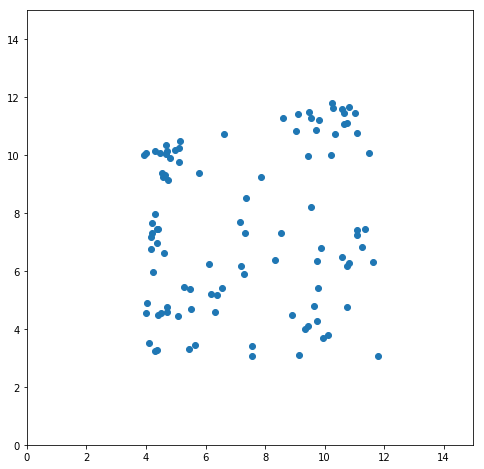

Epoch: [99/100], Batch Num: [0/100]
Discriminator Loss: 1.3860, Generator Loss: 0.7058
D(x): 0.4946, D(G(z)): 0.4942


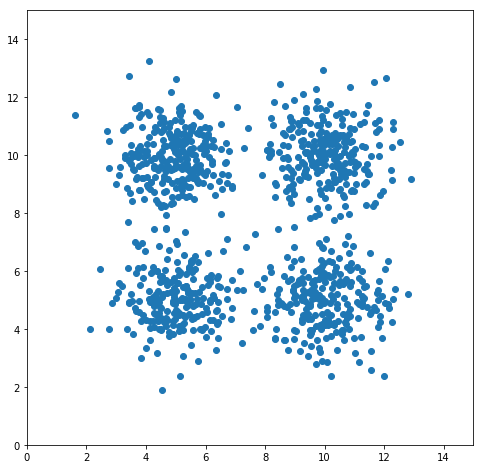

In [23]:
logger = Logger(model_name='midtermGAN', data_name='fourcircle')

for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(data_loader):

        # Train discriminator on a real batch and a fake batch
        
        real_data = real_batch.float()
#         if torch.cuda.is_available(): real_data = real_data.cuda()
        real_data = real_data.to(device)
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress

        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Plotting the generated outputs
            test_plot = plt_output(generator(test_noise).cpu().detach().numpy())
            
            
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            real_plot = plt_output(real_data.cpu().detach().numpy())
            
        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

## Results :

### Top = Generated data from test noise
### Bottom = Real Data

GAN has learned the distribution quite well

4. Suppose you are working on a regression problem for which you have insufficient data and come up with the idea of
   using a GAN to generate new $(\mathbf{x},y)$ pairs. First explain precisely how
   this could be done, then explain why it would be a bad idea.

We can generate new sample pairs using GAN by do doing just like what we have done in LAB7. We can train a Generator to Generate new sample pairs from seom noise then train the Discriminator to distinguish between real samples and fake samples then stop training when the Generated samples from GAN cannot be distinguish from the real samples anymore and the Discriminator always output 0.5. After training, we got a Generator which has hopefully learned the distribution of the data and we can then use it to create a new sample pairs sampled from the learned distribution. This way we can get larger number of sample pairs that we can then use for training the regression model to solve our problem.

However, in this case we don't have enough samples for a regression problem in the first place so I don't think the sample would be large enough for GAN to learn the data distribution, thus eventhough we can get more labeled data for training, we don't know if the generated samples from the trained generator would be a good representation of the real data distribution or not because we don't have enough real real data to validate that. That's why I think it would not be a good idea to use sample pairs created from GAN that learned from insufficient data to generate new sample pairs to use in supervised learning.

5. Briefly explain the purpose of weight decay and weight clipping, including how they are similar and how they are different.

Weight decay and weight clipping are similar in their purpose such that both of them aims to constrain the weights of the model. However, the way they do it is different.

Weight decay is a technique for regularizing the parameters or the weights of our model. It is used to prevent overfitting. The The idea is to make change to our objective function by adding the sum of squre of the weights vector to ensure small weights or what we called L2 penalty. However, in case that the weight vector grows too large, the learning algorithm might focus on minimizing the weight norm  ∥w∥^2 over minimizing the training error. Thus, when using weight decay sometimes it can be seen that the training error increases but the test error decrease. However, this can be mitigate by multiplying the sum of squares of weights with a small constant number λ to determine the strength of the penalty (to encouraging smaller weights). There are also come cases where weight decay is incorporated directly into the weight update rule, rather than just defining it through to objective function.

 Weight clipping is used to maintain the Lipschitz constraint. The idea of weight clipping is to clip the weights so that they are all in a specific range, hoping that keeping the weights small will cause the outputs to only make small changes. However, hard clipping results in most of the weights being very close to the lower/upper bound of the clipping interval which then cause vanishing gradient and exploding gradients so it is very hard to get the best hyper parameter c (which controls the range of clipping) that balances all the problems. Thus, soft penalizing has been introduced, where it forces the gradient's norm to be as close to 1 as possible, avoiding hard collapsing to a predefined values.

In both methods we can control them through the hyperparameters: λ, in weight decay and c in weight clipping.
